# Overfitting

In this section, we cover the topic of `overfitting`. A folk theorem is asset management is that people are so afraid of overfitting that they tend to (massively) underfit. Or at least, that was the case. Today, better fitting models to extract as much information from a dataset has become a crucial skill. 

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from IPython.display import display, Image

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from lightgbm.sklearn import LGBMRegressor

from ml4pmt.plot import line, bar
from ml4pmt.dataset import load_kf_returns
from ml4pmt.backtesting import MeanVariance, Backtester
from ml4pmt.metrics import sharpe_ratio
from ml4pmt.estimators import RidgeCV, MultiOutputRegressor, MLPRegressor

returns_data = load_kf_returns(cache_dir='data')
ret = returns_data['Monthly']['Average_Value_Weighted_Returns'][:'1999']

transform_X = lambda x: x.rolling(12).mean().fillna(0).values
transform_y = lambda x: x.shift(-1).values
features = transform_X(ret)
target = transform_y(ret)

INFO:ml4pmt.dataset:logging from cache directory: data/12_Industry_Portfolios


## Random parameter search for Lightgbm

https://lightgbm.readthedocs.io/en/latest/Parameters.html#learning-control-parameters

We first compute a `Lightgbm` benchmark with the fixed baseline parameters used in a previous section. 

In [40]:
estimator = make_pipeline(MultiOutputRegressor(LGBMRegressor(min_child_samples=5, 
                                                             n_estimators=25, n_jobs=1)), 
                          MeanVariance())

pnl_lgb = {'fixed_params':  Backtester(estimator, ret).train(features, target).pnl_ }

We now do a search with random parameters drawn from predetermined distribution: 
- the random parameter generators come from the `scipy.stats` module -- in particular `randint`, `uniform` and `loguniform`.
- we use the `scikit-learn` function `ParameterSampler` as wrapper. 

Setup: 
- the objective is to maximize the sharpe ratio over the early period 1945 to 1972 (as the `train` period). 
- the evaluation is the performance of the backtest over the 1972-to-2000 period (as the `test` period). 

In [3]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint, uniform, loguniform

In [4]:
n_iter = 50 
start_date = "1945-01-01"
end_date = "1972-04-01"
param_distributions = {"max_depth": randint(3, 10),
                       "num_leaves": randint(2, 2**8), 
                       "n_estimators": randint(5, 50), 
                       "min_split_gain": uniform(0, 1.0), 
                       "min_child_samples": randint(1, 5), 
                       "reg_lambda": loguniform(1e-8, 1.0), 
                       "reg_alpha": loguniform(1e-8, 1.0)
                      }
results_ = {}
for i, prm in tqdm(enumerate(ParameterSampler(param_distributions=param_distributions, n_iter=n_iter))): 
    estimator = make_pipeline(MultiOutputRegressor(LGBMRegressor(n_jobs=1, **prm)), 
                              MeanVariance())
    pnl_ = Backtester(estimator, ret, end_date=end_date).train(features, target).pnl_
    prm.update({'sr': pnl_.pipe(sharpe_ratio)})
    results_[i] = pd.Series(prm)

0it [00:00, ?it/s]

In [5]:
results = pd.DataFrame.from_dict(results_, orient='index').sort_values('sr')

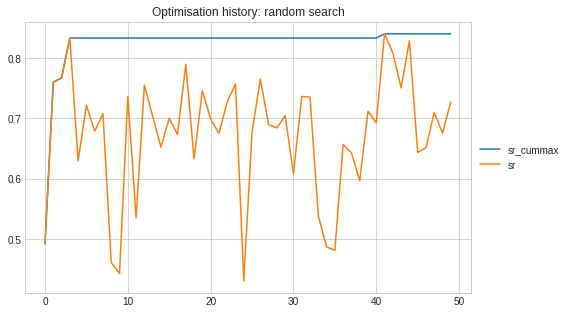

In [6]:
df = results.sort_index()[['sr']].assign(sr_cummax = lambda x: x.sr.cummax())
line(df, title='Optimisation history: random search')

Using the sharpe ratio statistics presented in a previous section, we can compute a standard error around the maximum sharpe ratio: 

In [7]:
sr_max = results.iloc[-1]['sr'] / np.sqrt(12)
sr_std = np.sqrt(12) * np.sqrt((1 + .5 * sr_max **2)/ len(ret[start_date:end_date])) 
sr_range = results['sr'].pipe(lambda x: x.max()-x.min())
print(f'The sharpe ratio standard deviation at the maximum sharpe ratio (of {sr_max * np.sqrt(12):.2f}) is {sr_std:.2f}')

print(f'The range of the sharpe ratios in the random search is {sr_range:.2f}')

The sharpe ratio standard deviation at the maximum sharpe ratio (of 0.84) is 0.19
The range of the sharpe ratios in the random search is 0.41


In [8]:
best_params = results.drop('sr', axis=1).iloc[-1].to_dict()
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params

{'max_depth': 3,
 'min_child_samples': 4,
 'min_split_gain': 0.7238898019462935,
 'n_estimators': 19,
 'num_leaves': 35,
 'reg_alpha': 6.375675585486511e-06,
 'reg_lambda': 0.1890466691933732}

In [9]:
estimator = make_pipeline(MultiOutputRegressor(LGBMRegressor(n_jobs=1, **best_params)), 
                          MeanVariance())
pnl_lgb['best_params'] = Backtester(estimator, ret).train(features, target).pnl_

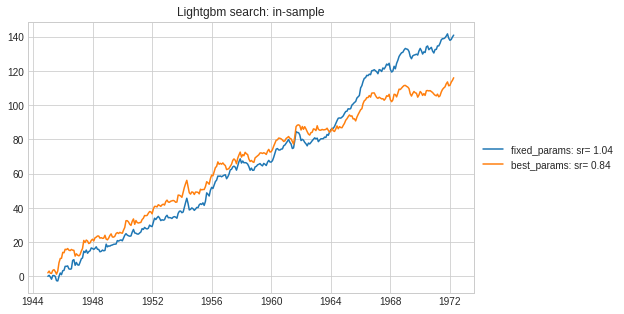

In [10]:
line({k: v.loc[start_date:end_date] for k, v in pnl_lgb.items()}, cumsum=True, title='Lightgbm search: in-sample')

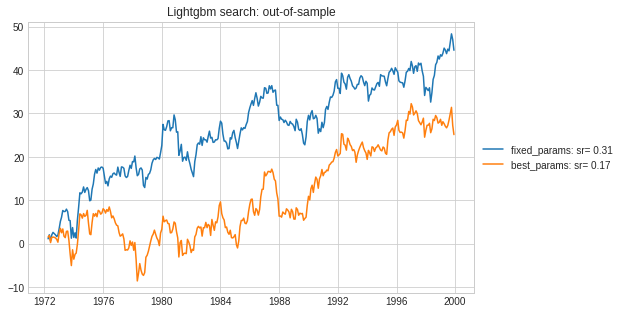

In [11]:
line({k: v.loc[end_date:] for k, v in pnl_lgb.items()}, cumsum=True, title='Lightgbm search: out-of-sample')

What are the parameters that are correlated with the sharpe ratio? 

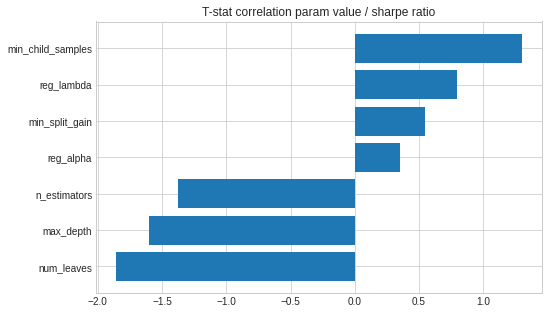

In [12]:
bar(results.corr()['sr'].mul(np.sqrt(n_iter)).drop('sr'), 
    title='T-stat correlation param value / sharpe ratio', horizontal=True)

To assess more precisely the impact of parameters on the sharpe ratio, we run a regression. 

In [13]:
from statsmodels import api
m = api.OLS(results["sr"], api.add_constant(results.drop('sr', axis=1))).fit()

In [14]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sr   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1.463
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.207
Time:                        10:55:16   Log-Likelihood:                 49.389
No. Observations:                  50   AIC:                            -82.78
Df Residuals:                      42   BIC:                            -67.48
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7597      0.087      8.779      0.000       0.585       0.934
max_depth            -0.0093      0.008     -1.111      0.273      -0.026       0.008
min_child_samples     0.0124      0.014      0.904      0.371      -0.015       0.040
min_split_gain        0.0303      0.052      0.585      0.562      -0.074       0.135
n_estimators         -0.0016      0.001     -1.433      0.159      -0.004       0.001
num_leaves           -0.0004      0.000     -1.851      0.071      -0.001    3.22e-05
reg_alpha             0.0285      0.120      0.238      0.813      -0.214       0.271
reg_lambda            0.1330      0.148      0.897      0.375      -0.166       0.432
==============================================================================
Omnibus:                        2.646   Durbin-Watson:                   0.380
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                2.311
Skew:                          -0.523   Prob(JB):                        0.315
Kurtosis:                       2.874   Cond. No.                     1.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Ridge CV

Another strategy is to use estimators that embed some form of cross-validation like `RidgeCV`.

K-fold cross validation is described as follows: 

Take a model with parameter $s$ (e.g. the Ridge with tuning parameter `alpha`): 

1. divide the data into $K$ roughly equal parts ($K = 5$ or $K = 10$)

1. for each $k \in \{1, 2,..., K\}$ fit the model with parameter $s$ to the other $K-1$ parts and compute its error $E_k(s)$  in predicting the $k$-th part.

1. the overall cross-validation error is then $CV(s)= \frac{1}{K} \sum_{k=1}^K E_k(s)$. 

1. do this for many values of $s$ and choose the value of s that minimize $CV (s)$

In [15]:
alphas = np.exp(np.arange(np.log(10),np.log(10001), (np.log(10000) - np.log(10))/10))

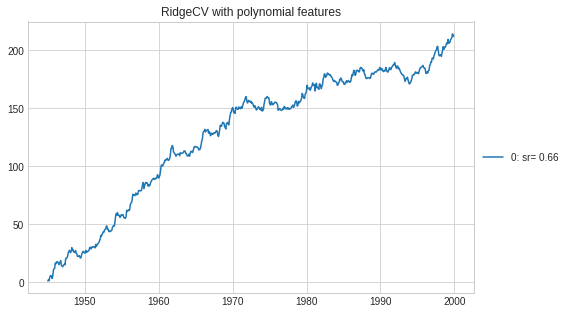

In [16]:
estimator = make_pipeline(StandardScaler(with_mean=False), 
                          PolynomialFeatures(degree=2), 
                          RidgeCV(alphas=alphas, cv=5), 
                          MeanVariance())

m = Backtester(estimator, ret).train(features, target)
line(m.pnl_, cumsum=True, title='RidgeCV with polynomial features')

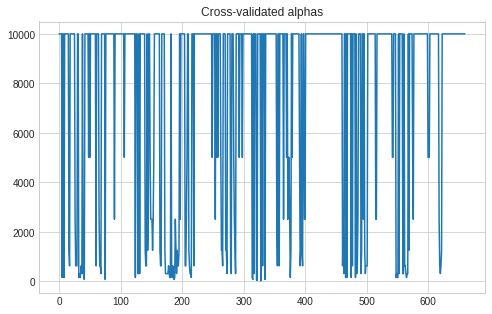

In [17]:
line(pd.Series([m[2].alpha_ for m in m.estimators_]), title='Cross-validated alphas', legend=False)

In this example, the fitted alphas over rolling windows are not very stable (probably given the small rolling windows used here).

## Ensemble 

Rather than choosing a single estimator (or set of parameters) among many, another stategy is to combine all the possible estimators/parameters. `scikit-learn` allows to do that with classes such as `VotingRegressor`.

In [18]:
from ml4pmt.estimators import Ridge
from sklearn.ensemble import VotingRegressor

class VotingRegressor(VotingRegressor):
    def transform(self, X):
        return self.predict(X)

In [19]:
estimators_ = [('ridge1', Ridge(alpha=1)),  
               ('ridge2', Ridge(alpha=100)), ]

By default, `VotingRegressor` applies equal weights across regressors. 

In [20]:
estimator = make_pipeline(StandardScaler(with_mean=False), 
                          MultiOutputRegressor(VotingRegressor(estimators=estimators_)), 
                          MeanVariance())

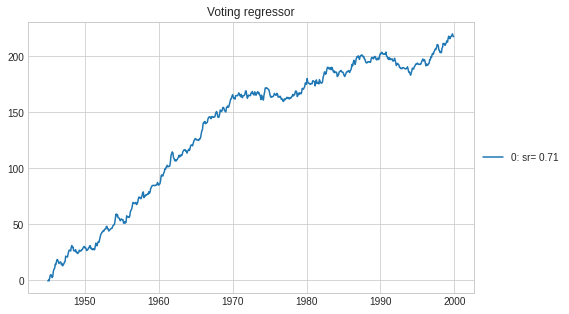

In [21]:
m = Backtester(estimator, ret).train(features, target)
line(m.pnl_, cumsum=True, title='Voting regressor')

In `scikit-learn`, there is also a `StackingRegressor` but it requires a bit more work to make it work with `MultiOutputRegressor` (and constraints on transform/regressors). 

## Rolling ensemble backtest

In this section, we build a custom ensemble method to learn weights on different estimators from pnls. 

### A shortcut to compute markowitz weights

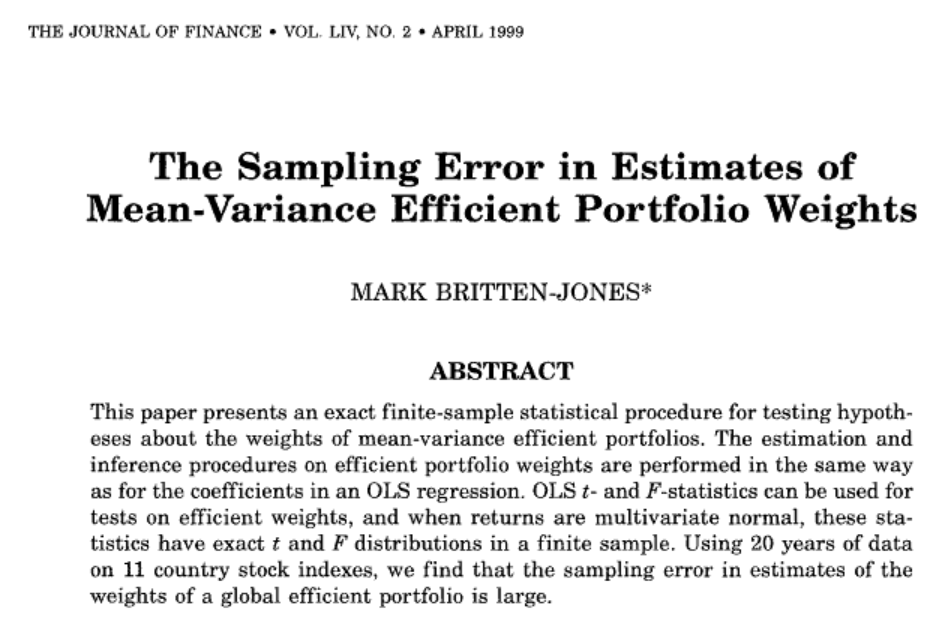

In [22]:
#hide
display(Image('images/mbj.png',width=500))

A final strategy is to learn weights based on pnl over rolling windows (longer than the estimation windows).

Trick to compute markowitz weights just with the pnl of different assets 

- X: pnl of $K$ assets over $T$ days -- so that the shape of X is $[T \times K]$. 

- y: vector of ones of size $T$. 

**Lemma** [Mark Britten-Jones]: the markowitz weights of are proportional to the slope coefficient of a regression of the vector of ones $y$ on the pnls $X$ *with no intercept*. 

Proof: the coefficient of the regression with no intercept is given by 

$$ b = (X^T X)^{-1} X^T y  $$

The mean of the pnls is given by $\mu = \frac{1}{T} X^T y$. The variance of the pnls is $V = \frac{1}{T} X^T X - \mu \mu^T$

Using the Woodbury identity (https://en.wikipedia.org/wiki/Woodbury_matrix_identity), we have: 

$$ b = (V + \mu \mu^{T})^{-1} \mu = \left[ V^{-1} -  \frac{V^{-1} \mu \mu^{T}V^{-1}}{1 + \mu^T V^{-1} \mu}  \right] \mu = \frac{V^{-1} \mu}{1 + \mu^T V^{-1} \mu} $$

The main trick is to recognise that 

$$(X^T X)^{-1} X^T y \propto [X^T X - (X^T y)^T  X^T y ]^{-1} X^T y$$

### StackingBacktester

In this section, we consider three estimators: 
    
- the simple Industry momentum. 

- a strategy that learns cross-industry effect with `Ridge`. 

- a strategy that learns cross-industry effect with `Lightgbm`. 

In [23]:
estimators = {'momentum': MeanVariance(), 
              'ridge':  make_pipeline(StandardScaler(with_mean=False), Ridge(), MeanVariance()), 
              'lightgbm': make_pipeline(MultiOutputRegressor(LGBMRegressor(min_child_samples=5, 
                                                             n_estimators=25, n_jobs=1)), MeanVariance())
             }

In [24]:
pnls = pd.concat({k: Backtester(v, ret).train(features, target).pnl_ for k, v in estimators.items()}, axis=1)

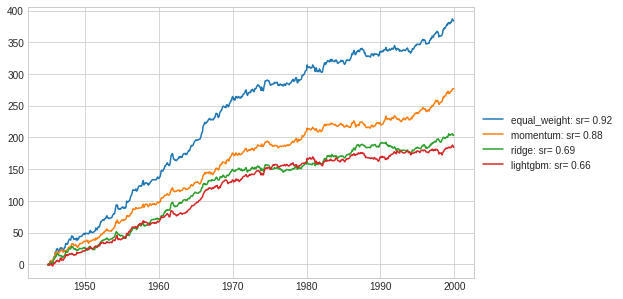

In [25]:
pnls_ = pnls.assign(equal_weight = lambda x: x.sum(axis=1).div(np.sqrt(x.shape[1])))
line(pnls_, cumsum=True)

The average correlation is not particularly high, which explains with some simple ensemble seems to help. 

In [26]:
print(f'The average pnl correlation between estimators is {pnls.corr().stack().loc[lambda x: x!=1].mean():.2f}')

The average pnl correlation between estimators is 0.50


We introduce a simple `MBJ` estimator and `StackingBacktester` with the `sklearn` api. 

In [27]:
%%writefile ../ml4pmt/ensemble.py
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.base import TransformerMixin
from sklearn.model_selection import TimeSeriesSplit

class Mbj(TransformerMixin): 
    def __init__(self, positive=False): 
        self.positive=positive 
        
    def fit(self, X, y=None): 
        m = LinearRegression(fit_intercept=False, positive=self.positive)
        m.fit(X, y = np.ones(len(X)))
        self.coef_ = m.coef_ / np.sqrt(np.sum(m.coef_**2))
        return self

    def transform(self, X): 
        return X.dot(self.coef_)
    

class StackingBacktester:
    def __init__(
        self,
        estimators,
        ret,
        max_train_size=36,
        test_size=1,
        start_date="1945-01-01",
        end_date=None,
        window=60, 
        min_periods=60, 
        final_estimator = Mbj()
    ):

        self.start_date = start_date
        self.end_date = end_date
        self.estimators = estimators
        self.ret = ret[: self.end_date]
        self.cv = TimeSeriesSplit(
            max_train_size=max_train_size,
            test_size=test_size,
            n_splits=1 + len(ret.loc[start_date:end_date]) // test_size,
        )
        self.window = window
        self.min_periods = min_periods
        self.final_estimator = final_estimator 

    def train(self, features, target):
        cols =self.ret.columns 
        idx = self.ret.index[np.concatenate([test for _, test in self.cv.split(self.ret)])]

        _h = {k: [] for k in list(self.estimators.keys()) + ['ensemble']}
        _pnls = {k: [] for k in self.estimators.keys()}
        _coef = []
        for i, (train, test) in enumerate(self.cv.split(self.ret)): 
            h_ = {}
            if (i> self.min_periods): 
                pnl_window = np.stack([np.array(v[-self.window:]) for k, v in _pnls.items()], axis=1)
                coef_ = self.final_estimator.fit(pnl_window).coef_
                _coef += [coef_]
            else: 
                _coef += [np.zeros(3)] 
            for k, m in self.estimators.items(): 
                m.fit(features[train], target[train])
                h_[k] = m.predict(features[test])
                _h[k] += [h_[k]]
                if i+1 <len(idx):
                    _pnls[k] += [self.ret.loc[idx[i+1]].dot(np.squeeze(h_[k]))]
            if (i>self.min_periods): 
                h_ensemble = np.stack([np.squeeze(v) for v in h_.values()], axis=1).dot(coef_).reshape(-1, 1)
                V_ = m.named_steps['meanvariance'].V_
                h_ensemble = h_ensemble / np.sqrt(np.diag(h_ensemble.T.dot(V_.dot(h_ensemble))))
            else: 
                h_ensemble = np.zeros([len(cols), 1])
            _h['ensemble'] += [h_ensemble.T]
            
        self.h_ = {k: pd.DataFrame(np.concatenate(_h[k]), index=idx, columns=cols) 
                   for k in _h.keys()}
        self.pnls_ = pd.concat({k: v.shift(1).mul(self.ret).sum(axis=1)[self.start_date:] 
                                for k, v in self.h_.items()}, 
                               axis=1)
        self.coef_ = pd.DataFrame(np.stack(_coef), index=idx, columns=self.estimators.keys())
        return self

Writing ../ml4pmt/ensemble.py


In [28]:
from ml4pmt.ensemble import Mbj

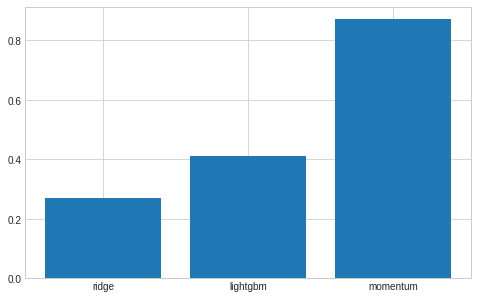

In [29]:
m = Mbj()
m.fit(pnls)
bar(pd.Series(m.coef_, index=pnls.columns))

The in-sample optimal weights improve even more the sharpe ratio -- but this is `in-sample`! 

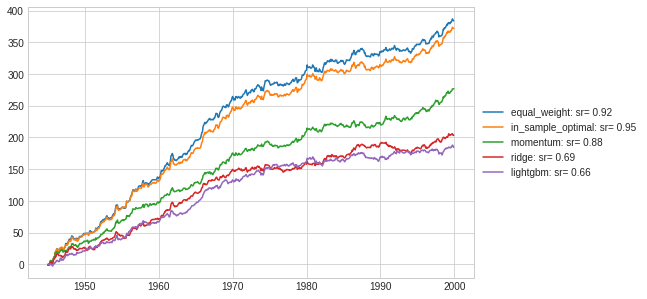

In [30]:
line(pnls_.assign(in_sample_optimal = Mbj().fit_transform(pnls)), cumsum=True)

The `StackingBacktester` computes the performance with the `MBJ` learned weights. 

In [31]:
from ml4pmt.ensemble import StackingBacktester

In [32]:
m = StackingBacktester(estimators=estimators, 
                       ret=ret, window=60,min_periods=60).train(features, target)
pnls = pnls.assign(ensemble_mbj= m.pnls_['ensemble'])

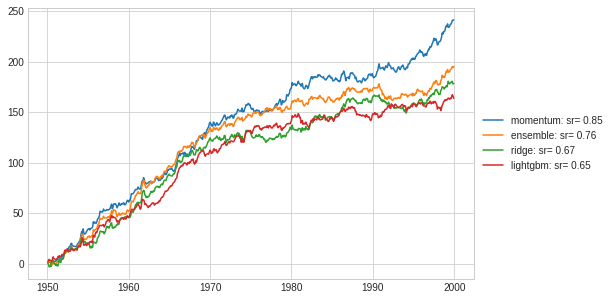

In [33]:
line(m.pnls_['1950-02-01':], cumsum=True)

To understand why the performance is lower, it is useful to look at the weights -- in this case, the weights are often negative. 

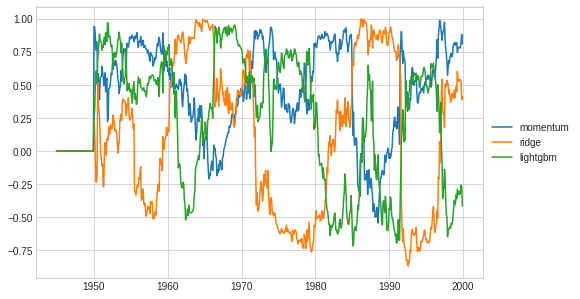

In [34]:
line(m.coef_)

We redo the exercise with a positive-weight constraint. 

In [35]:
m = StackingBacktester(estimators=estimators, 
                       final_estimator=Mbj(positive=True), 
                       ret=ret, 
                       window=60,
                       min_periods=60)
m.train(features, target)
pnls['ensemble_mbj_positive'] = m.pnls_['ensemble']

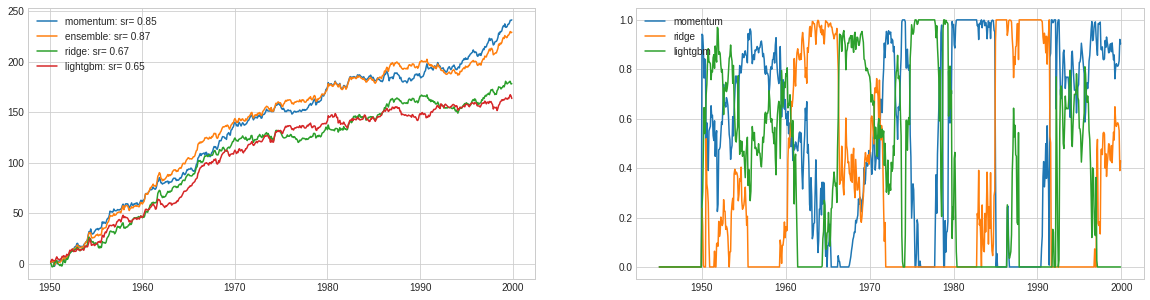

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
line(m.pnls_['1950-02-01':], cumsum=True, ax=ax[0], loc='best')
line(m.coef_, ax=ax[1], loc='best')

Over longer periods with positive constraints, the performance is closer to the industry momentum.

In [37]:
m = StackingBacktester(estimators=estimators, 
                       final_estimator=Mbj(positive=True), 
                       ret=ret, window=180,min_periods=60)

m.train(features, target)
pnls['ensemble_mbj_positive_long_window'] = m.pnls_['ensemble']

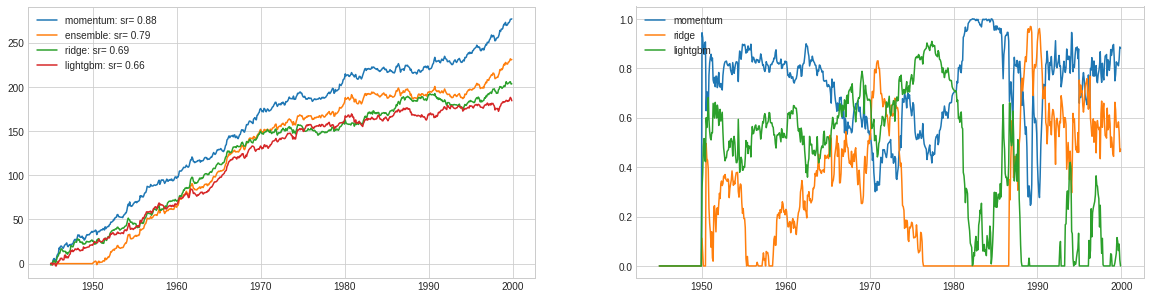

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
line(m.pnls_, cumsum=True, ax=ax[0], loc='best')
line(m.coef_, ax=ax[1], loc='best')

Putting the different ensembles, we compare the pnls in the graph below 

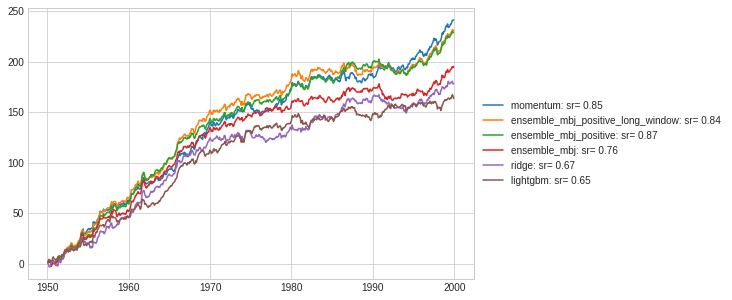

In [39]:
line(pnls['1950-02-01':], cumsum=True)